In [1]:
# Data Management/Investigation
import pandas as pd
from pandas.api.types import CategoricalDtype # Ordering categories
import numpy as np
import missingno as miss

# Plotting libraries
from plotnine import *
import matplotlib.pyplot as plt
import seaborn as sns

# For pre-processing data 
from sklearn import preprocessing as pp 
from sklearn.compose import ColumnTransformer 

# For splits and CV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold # Cross validation 
from sklearn.model_selection import cross_validate # Cross validation 
from sklearn.model_selection import GridSearchCV # Cross validation + param. tuning.

# Machine learning methods 
from sklearn.linear_model import LinearRegression as LM

from sklearn.neighbors import KNeighborsRegressor as KNN

from sklearn.tree import DecisionTreeRegressor as DTree
from sklearn.ensemble import BaggingRegressor as Bag

from sklearn.ensemble import RandomForestRegressor as RF


# For evaluating our model's performance
import sklearn.metrics as m

# Pipeline to combine modeling elements
from sklearn.pipeline import Pipeline

# For model interpretation
from sklearn.inspection import (
    permutation_importance,
    partial_dependence, 
    PartialDependenceDisplay, 
    plot_partial_dependence
)

# Misc
import warnings
warnings.filterwarnings("ignore")

from statsmodels.tsa.stattools import adfuller
import os
import statsmodels.api as sm
from numpy.random import normal, seed
from scipy.stats import norm
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARIMA
import math
from plotly import tools

from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.figure_factory as ff

## Data Manipulation

1.

In [2]:
#Create a new empty dataframe to store the data.
generation_monthly = pd.DataFrame()

In [3]:
#Load the data from the xlsx file and exclude those row that are nit useful.
for i in range(0, 5):#There are two iterations because different years have different useless rows.
    new_data = pd.read_excel('../data/generation_monthly.xlsx', i, header = None, skiprows = 1)
    generation_monthly = generation_monthly.append(new_data)
for j in range(5, 14):
    new_data = pd.read_excel('../data/generation_monthly.xlsx', j, header = None, skiprows = 5)
    generation_monthly = generation_monthly.append(new_data)

In [4]:
#Assign the proper column names and reset the index.
generation_monthly = generation_monthly.rename(columns={0: 'YEAR', 1: 'MONTH', 2: 'STATE', 3: 'TYPE_OF_PRODUCER', 4: 'ENERGY_SOURCE', 5: 'GENERATION\n(Megawatthours)',}).reset_index()

In [5]:
#Select the rows that contains VA and total generation.
generation_monthly = generation_monthly.query('STATE in ["VA"] and ENERGY_SOURCE in ["Total"] and TYPE_OF_PRODUCER in ["Total Electric Power Industry"]')

In [6]:
#Convert the date to datetime format.
generation_monthly["DATE"] = pd.to_datetime(generation_monthly.YEAR.astype(str) + '/' + generation_monthly.MONTH.astype(str) )

In [7]:
#Select the columns we need.
generation_monthly = generation_monthly[['DATE', 'GENERATION\n(Megawatthours)']]

In [8]:
#Take a look.
generation_monthly

,DATE,GENERATION\n(Megawatthours)
1408,2001-01-01,7117068.0
3079,2001-02-01,5894142.0
4754,2001-03-01,6358233.0
6431,2001-04-01,6108458.0
8110,2001-05-01,5592002.0
...,...,...
452053,2020-08-01,10066339.0
454175,2020-09-01,7691990.0
456296,2020-10-01,7007291.0
458418,2020-11-01,6938746.0


2.

In [9]:
#Load the data from the xlsx file
price = pd.read_excel('../data/sales_revenue.xlsx', skiprows = 2)[['Year', 'Month', 'State', 'Cents/kWh.5']]

In [10]:
#Drop the last row because it contains nothing useful.
price.drop(price.tail(1).index,inplace=True)

In [11]:
#convert year to int for later datetime transform.
price['Year'] = price['Year'].astype('int')

In [12]:
#Select the rows that contains VA and year between 2000 and 2021.
price = price.query('State in ["VA"] and Year > 2000 and Year <2021')

In [13]:
#Convert the date to datetime format.
price["DATE"] = pd.to_datetime(price.Year.astype(str) + '/' + price.Month.astype('int').astype(str) )

In [14]:
#Select the columns we need and rename one of the col name.
price = price[['DATE', 'Cents/kWh.5']].rename(columns={'Cents/kWh.5': 'PRICE(Cents/kWh.5)'})

In [15]:
#Take a look.
price

,DATE,PRICE(Cents/kWh.5)
6777,2001-01-01,5.86
6828,2001-02-01,6.03
6879,2001-03-01,6.06
6930,2001-04-01,6.05
6981,2001-05-01,6.17
...,...,...
18762,2020-08-01,9.50
18813,2020-09-01,9.12
18864,2020-10-01,8.77
18915,2020-11-01,8.83


3.

In [16]:
#Create a new empty dataframe to store the data.
consumption_monthly = pd.DataFrame()

In [17]:
#Load the data from the xlsx file and exclude those row that are nit useful.
for i in range(0, 2):#There are two iterations because different years have different useless rows.
    new_data = pd.read_excel('../data/consumption_monthly.xlsx', i ,header = None, skiprows = 1)
    consumption_monthly = consumption_monthly.append(new_data)
for j in range(2, 11):
    new_data = pd.read_excel('../data/consumption_monthly.xlsx', j, header = None, skiprows = 5)
    consumption_monthly = consumption_monthly.append(new_data)

In [18]:
#Assign the proper column names and reset the index.
consumption_monthly = consumption_monthly.rename(columns={0: 'YEAR', 1: 'MONTH', 2: 'STATE', 3: 'TYPE_OF_PRODUCER', 4: 'ENERGY_SOURCE (UNITS)', 5: 'CONSUMPTION',}).reset_index()

In [19]:
#Convert the date to datetime format.
consumption_monthly["DATE"] = pd.to_datetime(consumption_monthly.YEAR.astype(str) + '/' + consumption_monthly.MONTH.astype(str) )

In [20]:
#Select the rows that contains VA and total consumption of fossil fuels.
consumption_monthly = consumption_monthly.query('STATE in ["VA"] and TYPE_OF_PRODUCER in ["Total Electric Power Industry"]')

In [21]:
#Select the rows we need and pivot from ling to wide.
consumption_monthly = consumption_monthly[['DATE', 'ENERGY_SOURCE (UNITS)', 'CONSUMPTION']].pivot(index = 'DATE', columns='ENERGY_SOURCE (UNITS)', values='CONSUMPTION').reset_index().fillna(0)

In [22]:
#Take a look.
consumption_monthly

ENERGY_SOURCE (UNITS),DATE,Coal (Short Tons),Natural Gas (Mcf),Other Gases (Billion BTU),Petroleum (Barrels)
0,2001-01-01,1394053.0,1744687.0,0.0,1019395.0
1,2001-02-01,1225213.0,809796.0,0.0,525230.0
2,2001-03-01,1312509.0,732833.0,0.0,1170501.0
3,2001-04-01,1142288.0,1217777.0,0.0,1085490.0
4,2001-05-01,1129454.0,1012305.0,0.0,400489.0
...,...,...,...,...,...
235,2020-08-01,336033.0,45822538.0,0.0,78779.0
236,2020-09-01,69319.0,36587665.0,0.0,69386.0
237,2020-10-01,27096.0,32076827.0,0.0,32886.0
238,2020-11-01,93992.0,25479817.0,0.0,54436.0


4.

In [23]:
#Read the data from csv file.
average_temperature = pd.read_csv('../data/average_temperature.csv')

In [24]:
#Drop the rows that contains useless information.
average_temperature.drop(average_temperature.head(3).index,inplace=True)
average_temperature.drop(average_temperature.tail(1).index,inplace=True)

In [25]:
#Convert the date to datetime format.
average_temperature['DATE'] = pd.to_datetime(average_temperature['Virginia'], format="%Y%m")

In [26]:
#Select the columns we need and rename one of the col name.
average_temperature = average_temperature[['DATE', ' Average Temperature']].rename(columns={' Average Temperature': 'AverageTemperature'})

In [27]:
#Take a look.
average_temperature

,DATE,AverageTemperature
3,2001-01-01,34.3
4,2001-02-01,41.2
5,2001-03-01,42.0
6,2001-04-01,56.6
7,2001-05-01,63.0
...,...,...
238,2020-08-01,75.5
239,2020-09-01,66.4
240,2020-10-01,59.0
241,2020-11-01,51.3


5.

In [28]:
#Read the data from csv file.
precipitation = pd.read_csv('../data/precipitation.csv')

In [29]:
#Drop the rows that contains useless information.
precipitation.drop(precipitation.head(3).index,inplace=True)
precipitation.drop(precipitation.tail(1).index,inplace=True)

In [30]:
#Convert the date to datetime format.
precipitation['DATE'] = pd.to_datetime(precipitation['Virginia'], format="%Y%m")

In [31]:
#Select the columns we need and rename one of the col name.
precipitation = precipitation[['DATE', ' Precipitation']].rename(columns={' Precipitation': 'Precipitation'})

In [32]:
#Add a columns named covid to indicate whether that month has covid. We can add it to any dataframe expect the one that is from google search. Add it here just for convenience.
precipitation['covid'] = np.where(precipitation['DATE'] > '2020-02-01', 1, 0)

In [33]:
#Take a look.
precipitation

,DATE,Precipitation,covid
3,2001-01-01,2.27,0
4,2001-02-01,2.01,0
5,2001-03-01,4.45,0
6,2001-04-01,1.64,0
7,2001-05-01,4.88,0
...,...,...,...
238,2020-08-01,8.20,1
239,2020-09-01,6.31,1
240,2020-10-01,5.07,1
241,2020-11-01,5.15,1


6.

In [34]:
#Read the data from csv file.
multiTimeline = pd.read_csv('../data/multiTimeline.csv').reset_index()

In [35]:
#Drop the rows that contains useless information.
multiTimeline.drop(multiTimeline.head(1).index,inplace=True)
multiTimeline.drop(multiTimeline.tail(11).index,inplace=True)

In [36]:
#Convert the date to datetime format.
multiTimeline['DATE'] = pd.to_datetime(multiTimeline['index'])

In [37]:
#Rename the column and select the columns we need.
multiTimeline = multiTimeline.rename(columns={'Category: All categories': 'internet_search'})[['DATE', 'internet_search']]

In [38]:
#Take a look.
multiTimeline

,DATE,internet_search
1,2004-01-01,43
2,2004-02-01,43
3,2004-03-01,42
4,2004-04-01,46
5,2004-05-01,42
...,...,...
200,2020-08-01,72
201,2020-09-01,67
202,2020-10-01,69
203,2020-11-01,69


7.

In [39]:
#Merge them all together.
full_data = generation_monthly.merge(consumption_monthly, on='DATE').merge(multiTimeline,on='DATE', how = "left").merge(average_temperature, on='DATE').merge(precipitation, on='DATE').merge(price, on='DATE')

In [40]:
#Take a look.
full_data

,DATE,GENERATION\n(Megawatthours),Coal (Short Tons),Natural Gas (Mcf),Other Gases (Billion BTU),Petroleum (Barrels),internet_search,AverageTemperature,Precipitation,covid,PRICE(Cents/kWh.5)
0,2001-01-01,7117068.0,1394053.0,1744687.0,0.0,1019395.0,NaN,34.3,2.27,0,5.86
1,2001-02-01,5894142.0,1225213.0,809796.0,0.0,525230.0,NaN,41.2,2.01,0,6.03
2,2001-03-01,6358233.0,1312509.0,732833.0,0.0,1170501.0,NaN,42.0,4.45,0,6.06
3,2001-04-01,6108458.0,1142288.0,1217777.0,0.0,1085490.0,NaN,56.6,1.64,0,6.05
4,2001-05-01,5592002.0,1129454.0,1012305.0,0.0,400489.0,NaN,63.0,4.88,0,6.17
...,...,...,...,...,...,...,...,...,...,...,...
235,2020-08-01,10066339.0,336033.0,45822538.0,0.0,78779.0,72,75.5,8.20,1,9.50
236,2020-09-01,7691990.0,69319.0,36587665.0,0.0,69386.0,67,66.4,6.31,1,9.12
237,2020-10-01,7007291.0,27096.0,32076827.0,0.0,32886.0,69,59.0,5.07,1,8.77
238,2020-11-01,6938746.0,93992.0,25479817.0,0.0,54436.0,69,51.3,5.15,1,8.83


# EDA

In [41]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240 entries, 0 to 239
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   DATE                        240 non-null    datetime64[ns]
 1   GENERATION
(Megawatthours)  240 non-null    float64       
 2   Coal (Short Tons)           240 non-null    float64       
 3   Natural Gas (Mcf)           240 non-null    float64       
 4   Other Gases (Billion BTU)   240 non-null    float64       
 5   Petroleum (Barrels)         240 non-null    float64       
 6   internet_search             204 non-null    object        
 7   AverageTemperature          240 non-null    object        
 8   Precipitation               240 non-null    object        
 9   covid                       240 non-null    int64         
 10  PRICE(Cents/kWh.5)          240 non-null    float64       
dtypes: datetime64[ns](1), float64(6), int64(1), object(3)
memo

In [42]:
#Change the data types to the proper ones.
for col in ['internet_search', 'AverageTemperature', 'Precipitation']:
    full_data[col] = full_data[col].astype('float64')

full_data['covid'] = full_data['covid'].astype('category')

In [43]:
#See the distribution of all varibales.
full_data.describe()

,GENERATION\n(Megawatthours),Coal (Short Tons),Natural Gas (Mcf),Other Gases (Billion BTU),Petroleum (Barrels),internet_search,AverageTemperature,Precipitation,PRICE(Cents/kWh.5)
count,2.400000e+02,2.400000e+02,2.400000e+02,240.000000,2.400000e+02,204.000000,240.000000,240.000000,240.000000
mean,6.682560e+06,8.282579e+05,1.437275e+07,0.125000,2.511768e+05,47.975490,56.292500,3.893000,8.151167
std,1.339362e+06,4.033024e+05,1.169321e+07,1.936492,3.473069e+05,16.114871,14.414739,1.582855,1.282722
min,3.648252e+06,1.834000e+03,7.328330e+05,0.000000,1.093600e+04,23.000000,28.900000,0.590000,5.860000
25%,5.733043e+06,5.103430e+05,4.273844e+06,0.000000,3.273865e+04,35.000000,42.675000,2.927500,6.720000
50%,6.522116e+06,8.575586e+05,1.216916e+07,0.000000,8.448250e+04,46.000000,56.350000,3.795000,8.810000
75%,7.595757e+06,1.169260e+06,2.155257e+07,0.000000,3.263385e+05,59.000000,70.725000,4.855000,9.220000
max,1.093800e+07,1.580492e+06,4.896101e+07,30.000000,1.792966e+06,96.000000,78.700000,8.200000,9.760000


<AxesSubplot:>

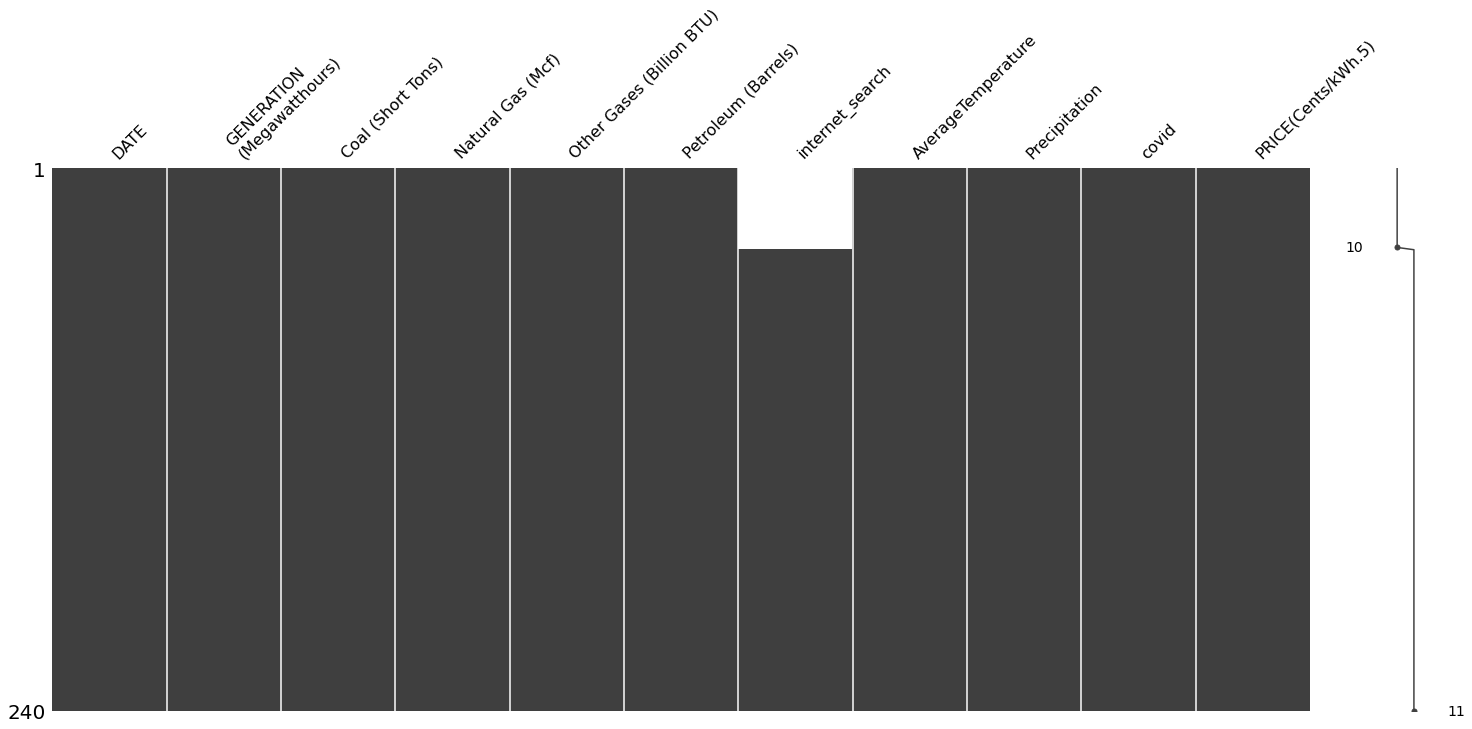

In [44]:
#Check the missing values.
miss.matrix(full_data)

In [45]:
#Since the google search did not come into being until 2004, I decided to fill the NAs with mode(it is also close to the mean)
full_data['internet_search'].fillna(full_data['internet_search'].mode()[0], inplace =True)

In [46]:
full_data.to_csv('full_data', index = False)

In [47]:
#Split the data.
y = full_data[['PRICE(Cents/kWh.5)']]
X = full_data.drop(columns=['PRICE(Cents/kWh.5)', 'DATE'])
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size = .20,random_state=520)

<AxesSubplot:>

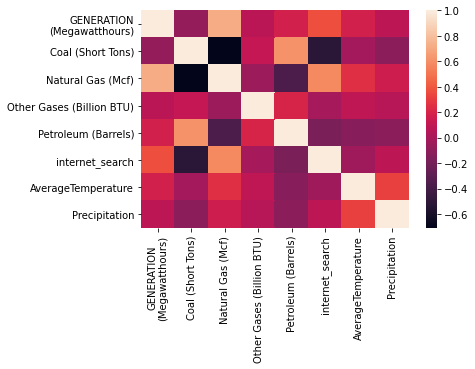

In [48]:
# correlations between features
corr_score = train_X[['GENERATION\n(Megawatthours)', 'Coal (Short Tons)',
       'Natural Gas (Mcf)', 'Other Gases (Billion BTU)', 'Petroleum (Barrels)',
       'internet_search', 'AverageTemperature', 'Precipitation', 'covid']].corr()

# show heapmap of correlations
sns.heatmap(corr_score)


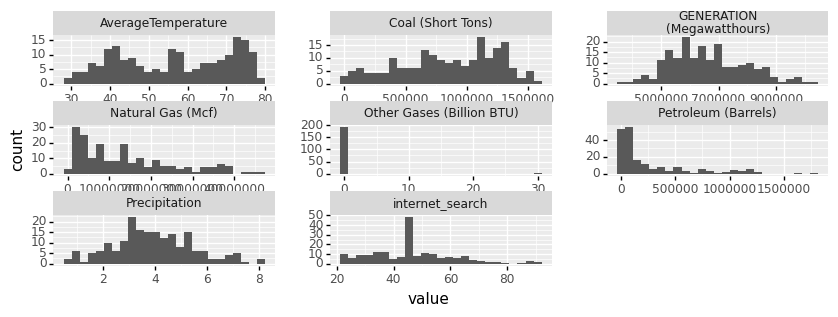

<ggplot: (8761439483299)>

In [49]:
# Plot the continuous Variables 
d = train_X.select_dtypes(include="float").melt()
(
    ggplot(d,aes(x="value")) +
    geom_histogram(bins=25) +
    facet_wrap("variable",scales='free') +
    theme(figure_size=(10,3),
          subplots_adjust={'wspace':0.25})
)

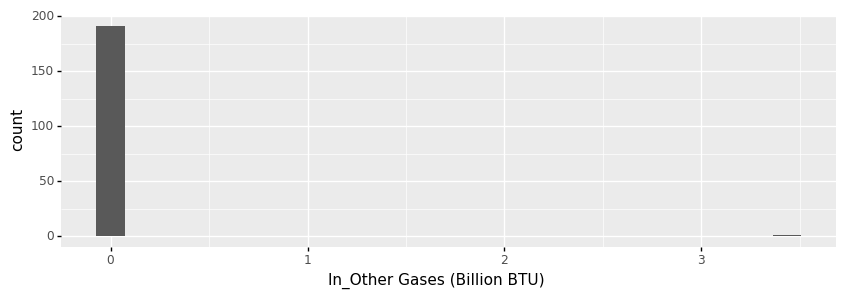

<ggplot: (8761441583463)>

In [50]:
d = train_X.copy()
d['ln_Other Gases (Billion BTU)'] =  np.log(d['Other Gases (Billion BTU)'] + 1)
(
    ggplot(d,aes(x="ln_Other Gases (Billion BTU)")) +
    geom_histogram(bins=25) +
    theme(figure_size=(10,3),
          subplots_adjust={'wspace':0.25})
)

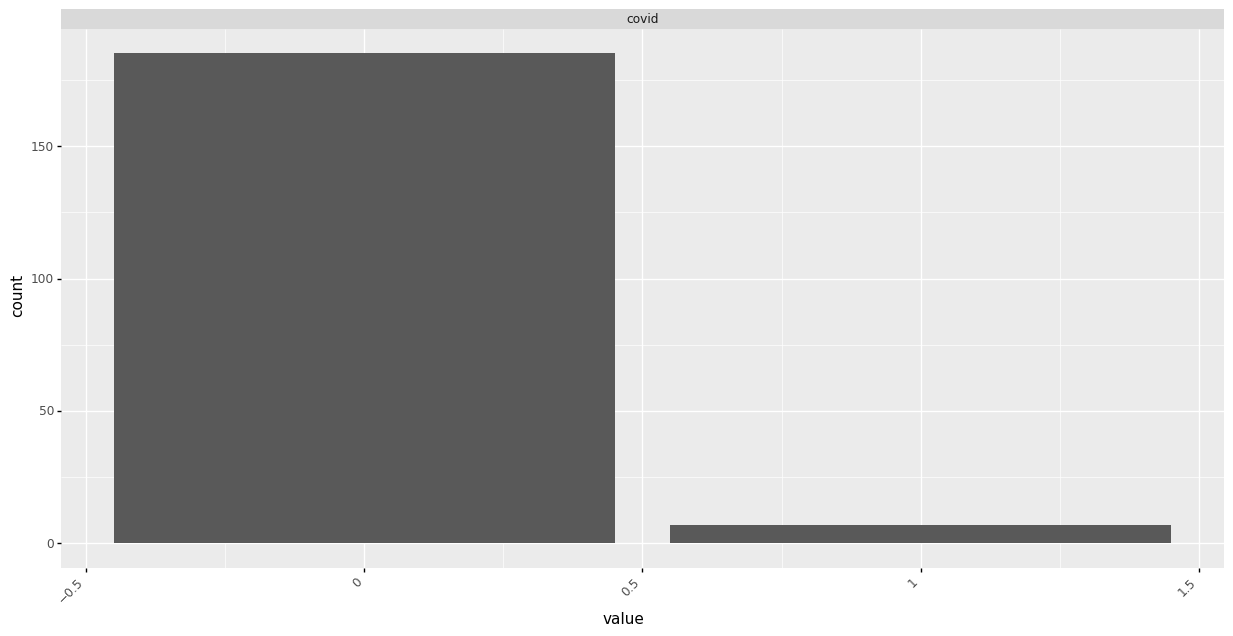

<ggplot: (8761439478872)>

In [51]:
d = train_X.select_dtypes(include="category").melt()
(
    ggplot(d,aes(x="value")) +
    geom_bar() +
    facet_wrap("variable",scales='free') +
    theme(figure_size=(15,7),
          subplots_adjust={'wspace':0.25,
                           'hspace':0.75},
         axis_text_x=element_text(rotation=45, hjust=1))
)

## High-level preprocessing

In [52]:
full_data = full_data.drop(columns=['Other Gases (Billion BTU)'])

In [53]:
#Resplit the data.
y = full_data[['PRICE(Cents/kWh.5)']]
X = full_data.drop(columns=['PRICE(Cents/kWh.5)', 'DATE'])
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size = .20,random_state=520)

In [54]:
train_X

,GENERATION\n(Megawatthours),Coal (Short Tons),Natural Gas (Mcf),Petroleum (Barrels),internet_search,AverageTemperature,Precipitation,covid
168,7697302.00,869227.00,17790748.00,166892.00,87.0,33.8,2.59,0
2,6358233.00,1312509.00,732833.00,1170501.00,46.0,42.0,4.45,0
62,6101973.00,1309486.25,2782041.42,27221.93,34.0,46.1,0.70,0
186,9824897.00,807485.00,37181299.00,126127.00,55.0,77.3,4.82,0
119,7070589.00,959588.00,13356200.00,502460.00,29.0,30.1,2.95,0
...,...,...,...,...,...,...,...,...
15,5595054.00,1088632.00,3319157.00,536676.00,46.0,57.7,3.20,0
212,8432940.00,287676.00,35210250.00,62614.00,59.0,72.8,7.96,0
155,6957509.44,914861.00,12941790.00,15084.00,53.0,40.3,5.81,0
107,6485334.00,1096837.00,6914608.00,33898.00,28.0,35.7,7.15,0


# Train Models

### Cross Validation 

In [55]:
# Set the folds index to ensure comparable samples
fold_generator = KFold(n_splits=10, shuffle=True,random_state=1234)

## Initialize Pipeline

Note that we still want to scale values, but we want to do this in the pipeline since it utilizes information we'll only learn from the training data (i.e. min/max, mean, std, etc.)

In [56]:
preprocess = ColumnTransformer(transformers=[('num', pp.MinMaxScaler(), ['GENERATION\n(Megawatthours)', 'Coal (Short Tons)', 'Natural Gas (Mcf)',  'Petroleum (Barrels)', 'internet_search', 'AverageTemperature', 'Precipitation'])])

In [57]:
pipe = Pipeline(steps=[('pre_process', preprocess),('model',None)])

## Select Models & Tuning Parameters

As before, the grid search to tune the models is pretty tame here so that the code will run quickly. Often a good idea to explore more of the tuning parameter space when running your own code. 

In [58]:
search_space = [
    # Linear Model
    {'model' : [LM()]},
    
    # KNN with K tuning param
    {'model' : [KNN()],
     'model__n_neighbors':[3,5,10,15,20,25,30]},
    
    # Decision Tree with the Max Depth Param
    {'model': [DTree()],
     'model__max_depth':[1,2,3,4,5]},
    
    # The Bagging decision tree model 
    {'model': [Bag()],
    'model__random_state':[0]},
    
    # Random forest with the N Estimators tuning param
    {'model' : [RF()],
     'model__max_depth':[1,2,3,4,5],
     'model__n_estimators':[100, 300,500,700,900],
    'model__random_state':[0]},
]

In [59]:
RF().get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

## Run Models

Put it all together in a GridSearch

In [60]:
search = GridSearchCV(pipe, search_space, 
                      cv = fold_generator,
                      scoring='neg_mean_squared_error',
                      n_jobs=4)

And Run

In [61]:
search.fit(train_X,train_y['PRICE(Cents/kWh.5)'])

GridSearchCV(cv=KFold(n_splits=10, random_state=1234, shuffle=True),
             estimator=Pipeline(steps=[('pre_process',
                                        ColumnTransformer(transformers=[('num',
                                                                         MinMaxScaler(),
                                                                         ['GENERATION\n'
                                                                          '(Megawatthours)',
                                                                          'Coal '
                                                                          '(Short '
                                                                          'Tons)',
                                                                          'Natural '
                                                                          'Gas '
                                                                          '(Mcf)',
                           

In [62]:
search.best_params_

{'model': RandomForestRegressor(max_depth=5, n_estimators=300, random_state=0),
 'model__max_depth': 5,
 'model__n_estimators': 300,
 'model__random_state': 0}

In [63]:
search.best_score_

-0.210063474329592

In [64]:
pred_y = search.predict(test_X)

In [65]:
m.mean_squared_error(test_y,pred_y)

0.158473388378258

In [66]:
m.r2_score(test_y,pred_y)

0.8956119467795509

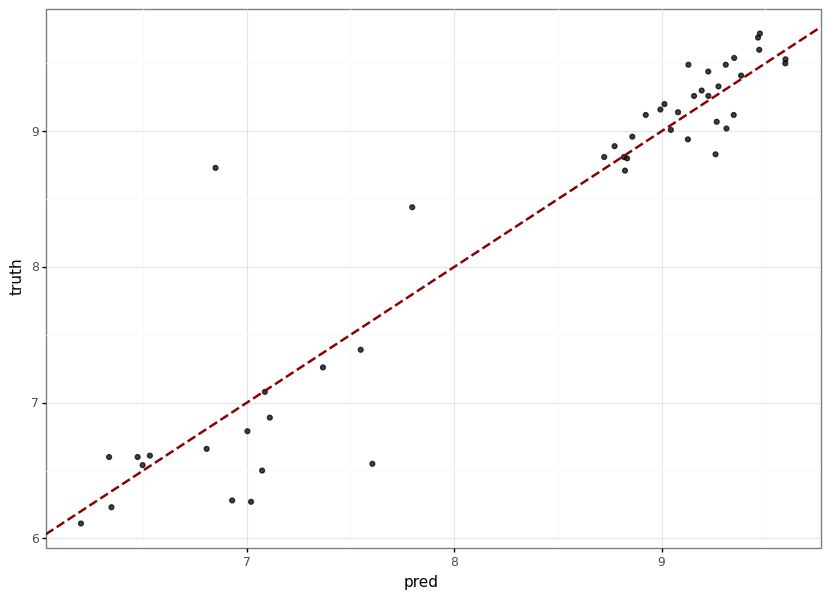

<ggplot: (8761441557384)>

In [67]:
(
    ggplot(pd.DataFrame(dict(pred=pred_y,truth=test_y['PRICE(Cents/kWh.5)'])),
          aes(x='pred',y="truth")) +
    geom_point(alpha=.75) +
    geom_abline(linetype="dashed",color="darkred",size=1) +
    theme_bw() +
    theme(figure_size=(10,7))
)

In [68]:
best_mod = search.best_estimator_

In [69]:
vi = permutation_importance(best_mod,train_X,train_y,n_repeats=5)

In [70]:
# Organize as a data frame 
vi_dat = pd.DataFrame(dict(variable=train_X.columns,
                           vi = vi['importances_mean'],
                           std = vi['importances_std']))

# Generate intervals
vi_dat['low'] = vi_dat['vi'] - 2*vi_dat['std']
vi_dat['high'] = vi_dat['vi'] + 2*vi_dat['std']

# But in order from most to least important
vi_dat = vi_dat.sort_values(by="vi",ascending=False).reset_index(drop=True)


vi_dat

,variable,vi,std,low,high
0,Natural Gas (Mcf),0.556277,0.026619,0.503039,0.609515
1,Coal (Short Tons),0.475107,0.030759,0.413588,0.536625
2,internet_search,0.113718,0.028839,0.056041,0.171396
3,AverageTemperature,0.010578,0.001670,0.007238,0.013918
4,GENERATION\n(Megawatthours),0.007227,0.000957,0.005313,0.009141
5,Petroleum (Barrels),0.002976,0.000169,0.002637,0.003315
6,Precipitation,0.001986,0.000264,0.001458,0.002515
7,covid,0.000000,0.000000,0.000000,0.000000


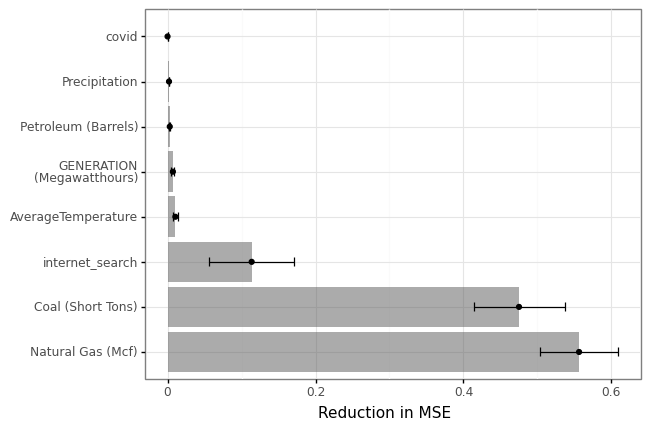

<ggplot: (8761441556839)>

In [71]:
# Plot
(
    ggplot(vi_dat,
          aes(x="variable",y="vi")) +
    geom_col(alpha=.5) +
    geom_point() +
    geom_errorbar(aes(ymin="low",ymax="high"),width=.2) +
    theme_bw() +
    scale_x_discrete(limits=vi_dat.variable.tolist()) +
    coord_flip() +
    labs(y="Reduction in MSE",x="")
)

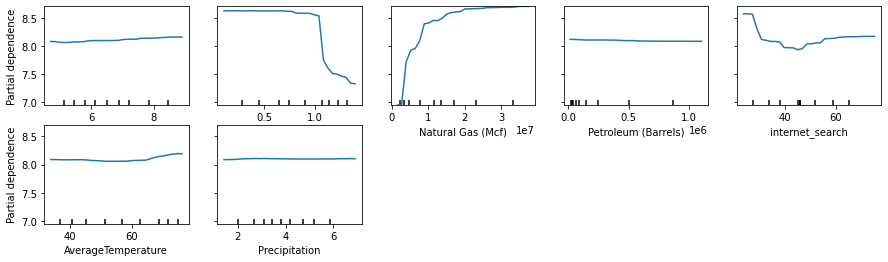

In [72]:
# Target specific features
features = ['GENERATION\n(Megawatthours)', 'Coal (Short Tons)', 'Natural Gas (Mcf)',  'Petroleum (Barrels)', 'internet_search', 'AverageTemperature', 'Precipitation']

# Calculate the partial dependency
fig, ax = plt.subplots(figsize=(15, 4))
display = plot_partial_dependence(
    best_mod, train_X, features,n_cols=5,
    n_jobs=4, grid_resolution=30,ax=ax
)
# display.figure_.set_figwidth(15)
# display.figure_.set_figheight(4)

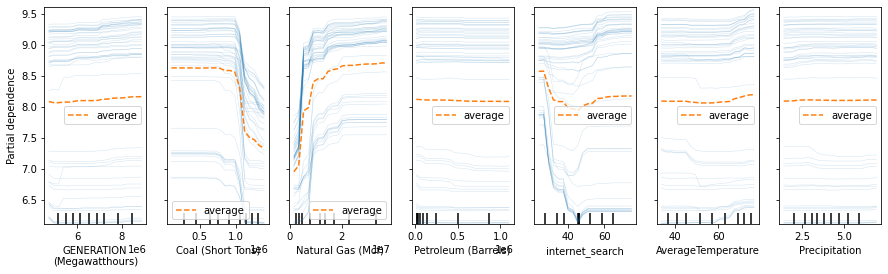

In [73]:
features = ['GENERATION\n(Megawatthours)', 'Coal (Short Tons)', 'Natural Gas (Mcf)',  'Petroleum (Barrels)', 'internet_search', 'AverageTemperature', 'Precipitation']
fig, ax = plt.subplots(figsize=(15, 4))
display = PartialDependenceDisplay.from_estimator(
    best_mod,
    train_X,
    features,
    kind="both", # "average" = just PDP, "individual" = just ICE
    subsample=50,
    n_jobs=3,
    grid_resolution=20,
    random_state=0,
    ice_lines_kw={"color": "tab:blue", "alpha": 0.2, "linewidth": 0.5},
    pd_line_kw={"color": "tab:orange", "linestyle": "--"},
    n_cols=len(features),
    ax = ax
)
display.figure_.subplots_adjust(hspace=0.3)

In [74]:
ts_dat = full_data[['DATE', 'PRICE(Cents/kWh.5)']].copy().set_index('DATE')

In [75]:
ts_dat

,PRICE(Cents/kWh.5)
DATE,
2001-01-01,5.86
2001-02-01,6.03
2001-03-01,6.06
2001-04-01,6.05
2001-05-01,6.17
...,...
2020-08-01,9.50
2020-09-01,9.12
2020-10-01,8.77


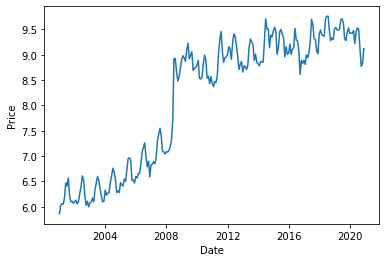

In [76]:
plt.xlabel('Date')
plt.ylabel('Price')
plt.plot(ts_dat)

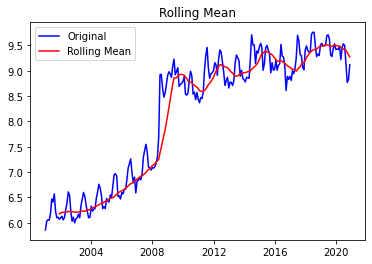

In [77]:
rollingmean = ts_dat.rolling(window=12).mean()
rollingstd = ts_dat.rolling(window=12).std()
orig = plt.plot(ts_dat, color='blue', label='Original')
mean = plt.plot(rollingmean , color='red', label='Rolling Mean')
#std = plt.plot(rollingstd, color='black', label='Rolling Std')
plt.plot(figsize=(10, 6))
plt.legend(loc='best')
plt.title('Rolling Mean')
plt.show(block=False)

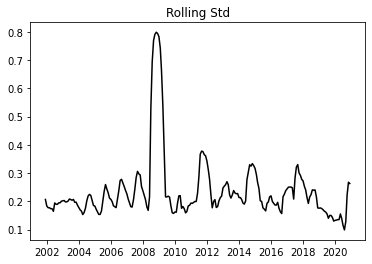

In [78]:
std = plt.plot(rollingstd, color='black', label='Rolling Std')
plt.title('Rolling Std')
plt.show(block=False)

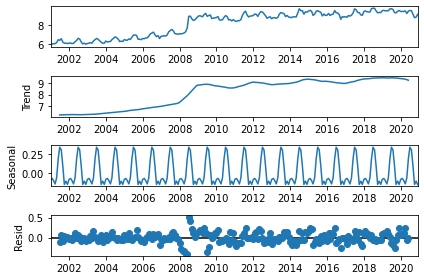

In [79]:
deco = sm.tsa.seasonal_decompose(ts_dat, model='additive')
fig = deco.plot()
plt.show()

In [80]:
deco.resid.describe()

count    228.000000
mean       0.001711
std        0.126386
min       -0.405965
25%       -0.065230
50%       -0.013596
75%        0.084183
max        0.525570
Name: resid, dtype: float64

In [81]:
deco.resid.isnull().sum()

12

In [82]:
PriceResidual = deco.resid
PriceResidual = PriceResidual.fillna(PriceResidual.bfill())
PriceResidual = PriceResidual.fillna(PriceResidual.ffill())

In [83]:
PriceResidual.describe()

count    240.000000
mean      -0.001737
std        0.124605
min       -0.405965
25%       -0.068383
50%       -0.016711
75%        0.082544
max        0.525570
Name: resid, dtype: float64

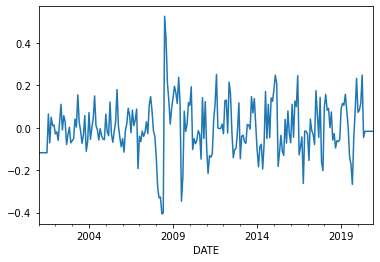

In [84]:
fig = PriceResidual.plot()
plt.show()

In [85]:
ADFresult = adfuller(PriceResidual)

In [86]:
ADFresult

(-8.559866798015571,
 8.754364654911672e-14,
 4,
 235,
 {'1%': -3.4584868856997004,
  '5%': -2.873918902362675,
  '10%': -2.573367247623359},
 -332.1849070829046)

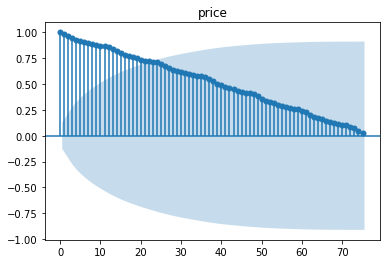

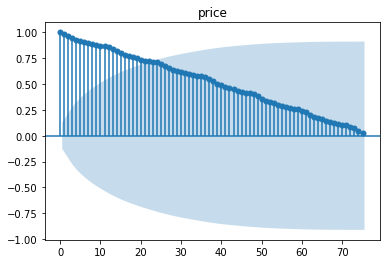

In [87]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
#plot_acf(CO2Residual,title="CO2")
plot_acf(ts_dat,lags=75,title="price")

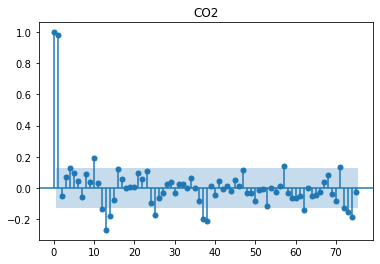

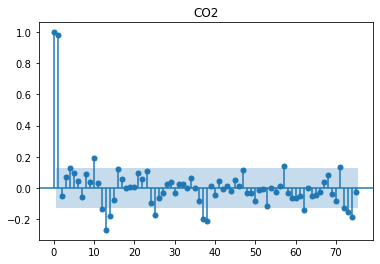

In [88]:
plot_pacf(ts_dat,lags=75,title="CO2")

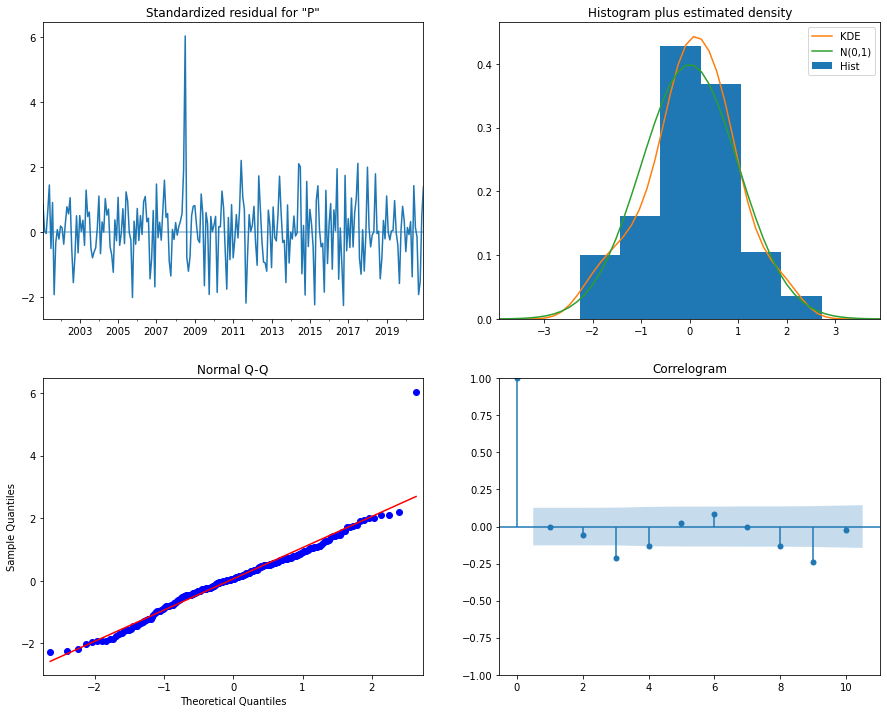

In [89]:
mod = sm.tsa.statespace.SARIMAX(ts_dat,
                                order=(1, 1, 1),
				)

TSresults = mod.fit()

#print(TSresults.summary().tables[1])

TSresults.plot_diagnostics(figsize=(15, 12))
plt.show()

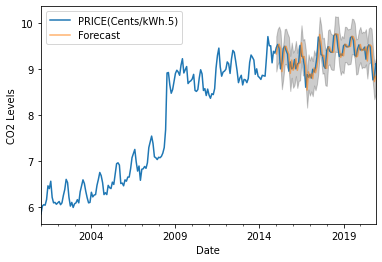

In [90]:
pred = TSresults.get_prediction(start=pd.to_datetime('2015-01-01'), dynamic=False)
pred_ci = pred.conf_int()
#Returns the confidence interval of the fitted parameters. 

ax = ts_dat['2001':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.6)

ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')
plt.legend()

plt.show()

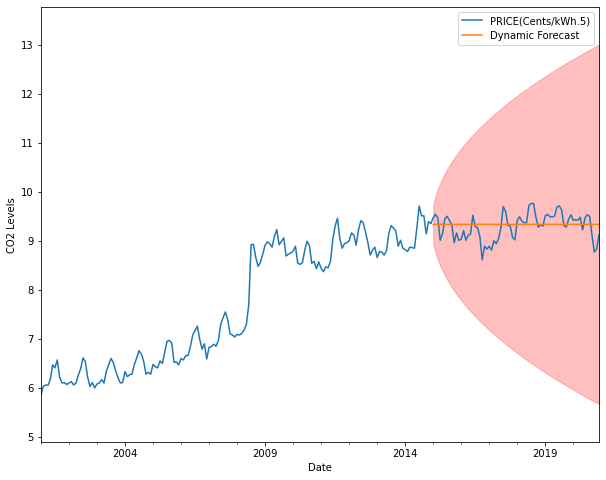

In [91]:
#pred_dynamic = TSresults.get_prediction(start=pd.to_datetime('1998-01-01'), dynamic=False, full_results=True)
pred_dynamic = TSresults.get_prediction(start=pd.to_datetime('2015-01-01'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()


ax = ts_dat['2001':].plot(label='observed', figsize=(10, 8))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)
ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='r', alpha=.25)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('1998-01-01'), y.index[-1],
                 alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')

plt.legend()
plt.show()